# Would you sell a life insurance to the Titanic passengers?

Thanks for **UPVOTING** this kernel! Trying to become a Kernel Expert. 👍

> Check out other interesting projects related to Titanic by Pavlo Fesenko:
- [(kernel) How to extend Titanic dataset using Wikipedia?](https://www.kaggle.com/pavlofesenko/extending-titanic-dataset-using-wikipedia)
- [(dataset) Titanic extended (Kaggle + Wikipedia)](https://www.kaggle.com/pavlofesenko/titanic-extended)

---
## Table of contents:
1. [Problem description](#1.-Problem-description)
2. [How is this problem different from the regular classification?](#2.-How-is-this-problem-different-from-the-regular-classification?)
3. [Preparing the data](#3.-Preparing-the-data)
4. [Training the model and adjusting precision](#4.-Training-the-model-and-adjusting-precision)
5. [Conclusion](#5.-Conclusion)

## 1. Problem description

Imagine that you have to decide whether to sell life insurances to the Titanic passengers and you know in advance that the ship is going to sink. Moreover, you have somehow obtained the anonymized features of the victims and survivors.

> *Could you minimize the number of insurance claims from the victims and at the same time maximize the total number of insurances that are sold to the passengers*?

This approach could be, for example, used by the insurance agencies that sell life insurances for high-risk clients with high-risk profession, habits, diseases, etc.

## 2. How is this problem different from the regular classification?

<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png">

Let's have a look at the results of the classification model that will be further described in Part 4:
* Correct predictions: 177 (survivors 61, victims 116)
* Wrong predictions: 46 (survivors 23, victims 23)

The overall accuracy score of this model seems to be quite good 177 / (177 + 46) = 0.79 but is it also good for our particular problem?

Note that this model has wrongly predicted 23 survivors (that actually died) meaning that the insurance agency has sold them insurances and now has to pay 23 insurance claims to the relatives of these victims. This is a huge cost! Ideally we want the number of wrongly predicted survivors to be 0. This type of wrong predictions is called *false positives* (see the figure on the right, cited from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)).

On the other hand, the model has wrongly predicted 23 victims (that actually survived) meaning that the agency hasn't sold 23 insurances to these people and lost potential customers. Nevertheless, this loss is significantly lower compared to the previous one since the cost of the insurance package is typically much lower than the cost of the insurance claim. This type of wrong predictions is called *false negatives* (see the figure).

To conclude, the incurance agency would prefer to **minimize the number of false positives** even if it might increase the number of false negatives.

For this purpose we will use the concepts of *precision* and *recall* that are defined below in the figure. As one can see from this definitions, **maximizing the precision minimizes the number of false positives**.

But how do we adjust our model to maximize the precision of the survivors? To make the long story short, we will need to adjust the threshold for class probabilities predicted by our model using a *Precision-Recall (or PR) curve*. More on that will come in the Part 4.

## 3. Preparing the data

Before we build our model using machine learning algorithms, let's prepare our dataset. We will go through the following stages:
1. Importing the data
2. Selecting the feature matrix `X` and the target column `y` (*supervised learning*)
3. Scaling numeric features
4. Encoding categorical features
5. Splitting the whole dataset into training and testing datasets

In the very beginning don't forget to import the required libraries. =)

In [1]:
# Silencing warnings from scikit-learn
import warnings
warnings.filterwarnings("ignore")

# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics

For the purpose of this demonstration we will only use the file `train.csv` that contains the target column.

In [2]:
# Importing data
data = pd.read_csv('../input/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The columns `PassengerId`, `Name`, `Ticket`, `Cabin` are excluded from the feature matrix `X` because the column `PassengerId` doesn't provide any useful information and the columns `Name`, `Ticket`, `Cabin` don't represent neither numeric nor categorical features. These columns can be used to generarte new features but it is an advanced topic and isn't covered in this kernel.

In [3]:
# Selecting the target column and the feature matrix
y = data['Survived']
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [4]:
# Checking the types of the columns and if they contain missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


The numeric and categorical features are separated since different prepocessing strategies are applied to them. Note that `Pclass` can be also considered a categorical feature. But since there is an order in the class numbers according to the luxury level (*ordinal feature*), it can be treated as numeric.

In [5]:
# Separating the feature matrix according to numeric and categorical features
num_feat = X.select_dtypes('number').columns.values
cat_feat = X.select_dtypes('object').columns.values
X_num = X[num_feat]
X_cat = X[cat_feat]

*Scaling* the numerical features below is important for convergence in some machine learning algorithms (for example, based on gradient descent). As a scaling method we chose standardization. Note that the NaN elements are filled in with the mean values of the corresponding columns.

In [6]:
# Scaling the numeric features using standardization
X_num = (X_num - X_num.mean()) / X_num.std()
X_num = X_num.fillna(X_num.mean())
X_num.head()

,Pclass,Age,SibSp,Parch,Fare
0,0.826913,-0.530005,0.432550,-0.473408,-0.502163
1,-1.565228,0.571430,0.432550,-0.473408,0.786404
2,0.826913,-0.254646,-0.474279,-0.473408,-0.488580
3,-1.565228,0.364911,0.432550,-0.473408,0.420494
4,0.826913,0.364911,-0.474279,-0.473408,-0.486064


*Encoding* the categorical features below is required since the machine learning algorithms work with numbers and not with strings. As an encoding method we chose one-hot encoding with dummmy variables. Note that the NaN elements are encoded with all 0 in the dummy variables so their additional filling is not required.

In [7]:
# Encoding the categorical features using one-hot encoding
X_cat = pd.get_dummies(X_cat)
X_cat.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1


In [8]:
# Combining processed numeric and categorical features in one feature matrix
X = pd.concat([X_num, X_cat], axis=1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.826913,-0.530005,0.432550,-0.473408,-0.502163,0,1,0,0,1
1,-1.565228,0.571430,0.432550,-0.473408,0.786404,1,0,1,0,0
2,0.826913,-0.254646,-0.474279,-0.473408,-0.488580,1,0,0,0,1
3,-1.565228,0.364911,0.432550,-0.473408,0.420494,1,0,0,0,1
4,0.826913,0.364911,-0.474279,-0.473408,-0.486064,0,1,0,0,1


The random state for the splitting below is fixed so that others could reproduce my results.

In [9]:
# Splitting the final dataset into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

## 4. Training the model and adjusting precision

As mentioned in the Part 1, to minimize the insurance claims from the victims we need to minimize the number of false positive errors or equivalently maximize the precision. This statement is obvious from the definition of the latter

$$ \text{Precision} = \frac{\text{true positives}}{\text{true positives + false positives}} $$.

In order to avoid false positives when predicting survived passengers, the classification threshold needs to clearly separate the training group of died passengers (true negatives or TN) from the rest (see the figure A below, cited from [Towards Data Science](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65)).

<img src="https://cdn-images-1.medium.com/max/800/1*J8kWRRekByVSJi8XDTSsgw.jpeg">

For example, for classification models that use a logistic loss function, this is a probability threshold (0.5 by default) for the outcome probabilities predicted by the model. If the predicted probability is higher than this threshold, the object is considered to be class "1" (survived passengers), otherwise the object is labeled to be class "0" (died passengers). To maximize the precision of survived passengers, the probability threshold needs to be much closer to 1.0 so that we only predict the survival of the passengers when the model thinks they have very high chances.

Variation of the classification threshold changes not only precision but also recall. To visualize these changes data scientists make a *Precision-Recall (or PR) curve*. Using this curve we can identify the point of maximum precision and the corresponding threshold.

For this problem I have chosen the classifier based on *stochastic gradient descent (or SGD)* with a logistic loss function. SGD is typically used for much larger datasets so other algorithms (for example, logistic regression) would be more appropriate here. However, SGD was one of the first classification algorithms that I learned and it is also great to demonstrate the importance of scaling the numeric features mentioned in Part 3.

In [10]:
# Fitting the model and printing the accuracy score
model = linear_model.SGDClassifier(loss='log', max_iter=2000, random_state=0) # Random state is fixed for reproducibility
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7937219730941704

Since SGD calculates the gradient only of the random part of the dataset (hence the name "stochastic"), the accuracy score might decrease after some of the iterations. Nevertheless, the score should be converging. This convergence should always be checked to ensure that the optimum point is reached. On the plot below the model converged after 1500 iterations so this or higher value should be used for the maximum number of iterations. Above we used 2000 iterations so it should suffice.

**Try it yourself:** Scaling of the numeric features helps a lot with the convergence of the SGD classifier. Try to comment the code that does scaling and rerun all the cells. You will see that the convergence doesn't occur. In this case you need to set the parameter `learning_rate='constant'` and manually decrease the parameter `eta0` until the convergence occurs again.

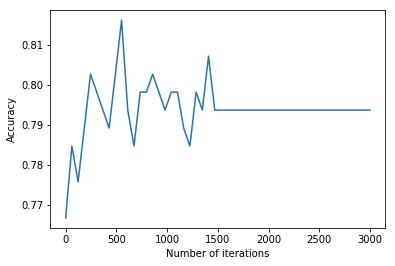

In [11]:
# Checking the convergence of the model
n_iter = np.linspace(1, 3000)
scores = np.array([])
for n in n_iter:
    model = linear_model.SGDClassifier(loss='log', max_iter=n, random_state=0)
    model.fit(X_train, y_train)
    scores = np.append(scores, model.score(X_test, y_test))
    
plt.plot(n_iter, scores)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.show()

Now that the convergence is confirmed, let's calculate the confusion matrix of our model. These values were used in Part 1 to explain the problem:

* Correct predictions: 177 (survivors 61, victims 116)
* Wrong predictions: 46 (survivors 23, victims 23)

In [12]:
# Printing the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[116,  23],
       [ 23,  61]])

The precision score for the survived passengers is decent (see below) but not good enough for our specific problem that requires precision to be as high as possible.

In [13]:
# Printing the precision score for survived passengers
metrics.precision_score(y_test, y_pred)

0.7261904761904762

Let's plot the Precision-Recall curve and find a point with a better precsion. Note that precision, recall and corresponding thresholds are obtained from the training dataset, not the testing dataset, to avoid biased scores.

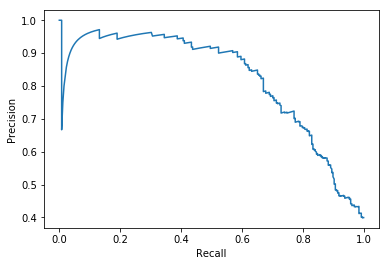

In [14]:
# Plotting the Precision-Recall curve
y_proba_train = model.predict_proba(X_train)[:, 1]
p, r, t = metrics.precision_recall_curve(y_train, y_proba_train)

plt.plot(r, p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The best precision of 1.0 is obtained for thresholds of 0.973211, 0.974678 and 1.0 (see the last 3 rows in the dataframe below). Let's pick up the threshold 0.973211 that corresponds to the highest recall among them. The higher the recall, the more true positives (or survived passengers) are predicted and the more insurances we will sell.

In [15]:
# Printing the last 5 combinations of precision-recall-threshold
prt = np.array(list(zip(p, r, t)))
prt_df = pd.DataFrame(data=prt, columns=['Precision', 'Recall', 'Threshold'])
prt_df.tail()

,Precision,Recall,Threshold
558,0.800000,0.015504,0.965561
559,0.750000,0.011628,0.969996
560,0.666667,0.007752,0.970968
561,1.000000,0.007752,0.973211
562,1.000000,0.003876,0.974678


If we apply this threshold to the probabilities for our testing dataset, we will find out, however, that none of them pass the threshold. For us it means that no insurances will be sold at all. Therefore, we might want to lower our precision to the next largest value on the PR curve.

In [16]:
# Counting the number of predicted survivors
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba_test >= 0.973211).astype(int)
np.count_nonzero(y_pred)

0

If you look again at the PR curve, you will notice that the precision rapidly drops at first but then recovers to 0.971429, the next highest value after 1.0 (see the row 529 below). This precision corresponds to the threshold 0.932465 and has much higher recall than in the previous case.

In [17]:
# Printing the last 50 combinations of precision-recall-threshold
prt_df.tail(50)

,Precision,Recall,Threshold
513,0.960784,0.189922,0.903174
514,0.960000,0.186047,0.906782
515,0.959184,0.182171,0.909994
516,0.958333,0.178295,0.910013
517,0.957447,0.174419,0.912081
518,0.956522,0.170543,0.913555
519,0.955556,0.166667,0.914014
520,0.954545,0.162791,0.914128
521,0.953488,0.158915,0.915179
522,0.952381,0.155039,0.918781


If we now select survivors based on the new probability threshold, we finally obtain a nonzero number of survivors. In this particular case 13 people.

In [18]:
# Counting the number of predicted survivors using the new threshold
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba_test >= 0.932465).astype(int)
np.count_nonzero(y_pred)

13

Furthermore, we can check how well the target variables correspond with our predictions. It turns out that there is a perfect match (precision of 1.0) and it is even better than the precision that we aimed on the training dataset.

In [19]:
# Pairs of target labels and predicted probabilities above the new threshold
yy = np.array(list(zip(y_test, y_proba_test)))
indices = np.where(yy[:,1] >= 0.932465)
yy[indices]

array([[1.        , 0.94751319],
       [1.        , 0.93842582],
       [1.        , 0.96626347],
       [1.        , 0.95822958],
       [1.        , 0.95844455],
       [1.        , 0.95454875],
       [1.        , 0.95465325],
       [1.        , 0.94716191],
       [1.        , 0.94935889],
       [1.        , 0.97058184],
       [1.        , 0.94185192],
       [1.        , 0.95991282],
       [1.        , 0.95343004]])

## 5. Conclusion

Let's compare what we had before and after the threshold adjustment.

* *Before*: 61 correctly predicted survivors, 23 wrongly predicted survivors, precision 0.73.
* *After*: 13 correctly predicted survivors, 0 wrongly predicted survivors, precision 1.0.

So in the end we managed to decrease the number of insurance claims down to 0 and at the same time sold insurances to 13 people. This is also confirmed by the precision score that has increased from 0.73 up to 1.0.

---
Thanks for **UPVOTING** this kernel! Trying to become a Kernel Expert. 👍

> Check out other interesting projects related to Titanic by Pavlo Fesenko:
- [(kernel) How to extend Titanic dataset using Wikipedia?](https://www.kaggle.com/pavlofesenko/extending-titanic-dataset-using-wikipedia)
- [(dataset) Titanic extended (Kaggle + Wikipedia)](https://www.kaggle.com/pavlofesenko/titanic-extended)